In [1]:
!pip install --upgrade --quiet catboost openpyxl scikit-learn joblib

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from catboost import CatBoostClassifier
import time
import joblib

In [29]:
df = pd.read_excel("parsed_data_new_balanced.xlsx")

print("Первые строки датафрейма:")
df.head()

Первые строки датафрейма:


,project,type,category,title,publish_date,fronturl,picture,overview,text,word_count
0,РБК,short_news,Авто,Глава АвтоВАЗа заявил о снижении продаж в феврале,2025-02-25T22:18:33+03:00,https://www.rbc.ru/rbcfreenews/67be10c59a79474...,1,NaN,В феврале 2025 года концерн АвтоВАЗ ожидает сн...,304
1,РБК,short_news,Авто,Юрист напомнил о штрафах за мытье машины на да...,2025-03-23T10:32:08+03:00,https://www.rbc.ru/rbcfreenews/67dfb71e9a79479...,1,NaN,Сотрудники ГИБДД могут оштрафовать автомобилис...,290
2,РБК,short_news,Авто,Минпромторг представил список облагаемых налог...,2025-03-29T19:43:30+03:00,https://www.rbc.ru/rbcfreenews/67e81d279a7947d...,1,В первый список внесены 303 модели средней сто...,Минпромторг России составил список дорогостоящ...,333
3,Autonews,short_news,Авто,В России стартовали продажи Volkswagen Golf. Н...,2025-01-06T22:51:30+03:00,https://www.autonews.ru/news/677bdc9b9a7947668...,1,NaN,В России возобновили продажи новых хэтчбеков V...,175
4,Autonews,short_news,Авто,В России назвали самые популярные пикапы. Цены...,2025-01-06T15:11:35+03:00,https://www.autonews.ru/news/677bc85d9a7947904...,1,NaN,"В России резко вырос спрос на пикапы. Так, по ...",403


In [30]:
def truncate_to_n_words(text, n=56):
    words = str(text).split()
    return ' '.join(words[:n])

df['text'] = df['text'].apply(lambda x: truncate_to_n_words(x, 56))

In [31]:
df.head()

,project,type,category,title,publish_date,fronturl,picture,overview,text,word_count
0,РБК,short_news,Авто,Глава АвтоВАЗа заявил о снижении продаж в феврале,2025-02-25T22:18:33+03:00,https://www.rbc.ru/rbcfreenews/67be10c59a79474...,1,NaN,В феврале 2025 года концерн АвтоВАЗ ожидает сн...,304
1,РБК,short_news,Авто,Юрист напомнил о штрафах за мытье машины на да...,2025-03-23T10:32:08+03:00,https://www.rbc.ru/rbcfreenews/67dfb71e9a79479...,1,NaN,Сотрудники ГИБДД могут оштрафовать автомобилис...,290
2,РБК,short_news,Авто,Минпромторг представил список облагаемых налог...,2025-03-29T19:43:30+03:00,https://www.rbc.ru/rbcfreenews/67e81d279a7947d...,1,В первый список внесены 303 модели средней сто...,Минпромторг России составил список дорогостоящ...,333
3,Autonews,short_news,Авто,В России стартовали продажи Volkswagen Golf. Н...,2025-01-06T22:51:30+03:00,https://www.autonews.ru/news/677bdc9b9a7947668...,1,NaN,В России возобновили продажи новых хэтчбеков V...,175
4,Autonews,short_news,Авто,В России назвали самые популярные пикапы. Цены...,2025-01-06T15:11:35+03:00,https://www.autonews.ru/news/677bc85d9a7947904...,1,NaN,"В России резко вырос спрос на пикапы. Так, по ...",403


In [32]:
df = df.dropna(subset=["title", "text", "category"])

print("Пример объединённого текста и количества слов:")
df[["text"]].head()

Пример объединённого текста и количества слов:


,text
0,В феврале 2025 года концерн АвтоВАЗ ожидает сн...
1,Сотрудники ГИБДД могут оштрафовать автомобилис...
2,Минпромторг России составил список дорогостоящ...
3,В России возобновили продажи новых хэтчбеков V...
4,"В России резко вырос спрос на пикапы. Так, по ..."


In [34]:
y = df["category"]

vectorizer = TfidfVectorizer(
    max_features=5000,
    min_df=5,
    stop_words=None
)

X_tfidf = vectorizer.fit_transform(df["text"].astype(str)).toarray()

X = np.hstack([X_tfidf])

print(f"Форма матрицы признаков: {X.shape}")

Форма матрицы признаков: (25151, 5000)


In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42, stratify=y)

print("Размер обучающей выборки:", X_train.shape)
print("Размер тестовой выборки:", X_test.shape)

Размер обучающей выборки: (12575, 5000)
Размер тестовой выборки: (12576, 5000)


In [36]:
#Классификация с CatBoost
model = CatBoostClassifier(
    iterations=1500,
    depth=10,
    learning_rate=0.03,
    loss_function='MultiClass',
    task_type='GPU',
    devices='0',
    verbose=100
)

model.fit(X_train, y_train)

0:	learn: 2.1459934	total: 838ms	remaining: 20m 55s
100:	learn: 1.2593792	total: 1m 6s	remaining: 15m 15s
200:	learn: 1.0917787	total: 2m 9s	remaining: 13m 58s
300:	learn: 0.9936031	total: 3m 13s	remaining: 12m 51s
400:	learn: 0.9232169	total: 4m 16s	remaining: 11m 43s
500:	learn: 0.8713263	total: 5m 19s	remaining: 10m 37s
600:	learn: 0.8292954	total: 6m 23s	remaining: 9m 33s
700:	learn: 0.7944304	total: 7m 26s	remaining: 8m 28s
800:	learn: 0.7645847	total: 8m 29s	remaining: 7m 24s
900:	learn: 0.7392666	total: 9m 31s	remaining: 6m 20s
1000:	learn: 0.7173910	total: 10m 34s	remaining: 5m 16s
1100:	learn: 0.6991820	total: 11m 35s	remaining: 4m 12s
1200:	learn: 0.6818206	total: 12m 38s	remaining: 3m 8s
1300:	learn: 0.6674028	total: 13m 39s	remaining: 2m 5s
1400:	learn: 0.6535201	total: 14m 41s	remaining: 1m 2s
1499:	learn: 0.6412673	total: 15m 42s	remaining: 0us


In [ ]:
word_count = df["title"].astype(str).apply(lambda x: len(x.split())).values.reshape(-1, 1)
X = np.hstack([X_tfidf, word_count])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

model = CatBoostClassifier(
    iterations=200,
    depth=6,
    learning_rate=0.03,
    l2_leaf_reg=5,
    loss_function='MultiClass',
    task_type='GPU',
    devices='0',
    random_seed=42,
    verbose=100
)

model.fit(X_train, y_train)

In [37]:
y_pred = model.predict(X_test)

print("\n📊 Classification Report:")
print(classification_report(y_test, y_pred))


📊 Classification Report:
                    precision    recall  f1-score   support

              Авто       0.93      0.89      0.90      1750
            Бизнес       0.60      0.69      0.64      1810
             Жилье       0.94      0.90      0.92       739
          Общество       0.63      0.75      0.68      1742
          Политика       0.70      0.80      0.75      2000
             Спорт       0.98      0.88      0.93      1125
Технологии и медиа       0.78      0.56      0.65      1237
           Финансы       0.77      0.66      0.71       913
         Экономика       0.63      0.53      0.58      1260

          accuracy                           0.74     12576
         macro avg       0.77      0.74      0.75     12576
      weighted avg       0.75      0.74      0.74     12576



In [21]:
y_test.head()

,category
11578,Общество
11190,Спорт
10877,Общество
6878,Политика
26355,Финансы


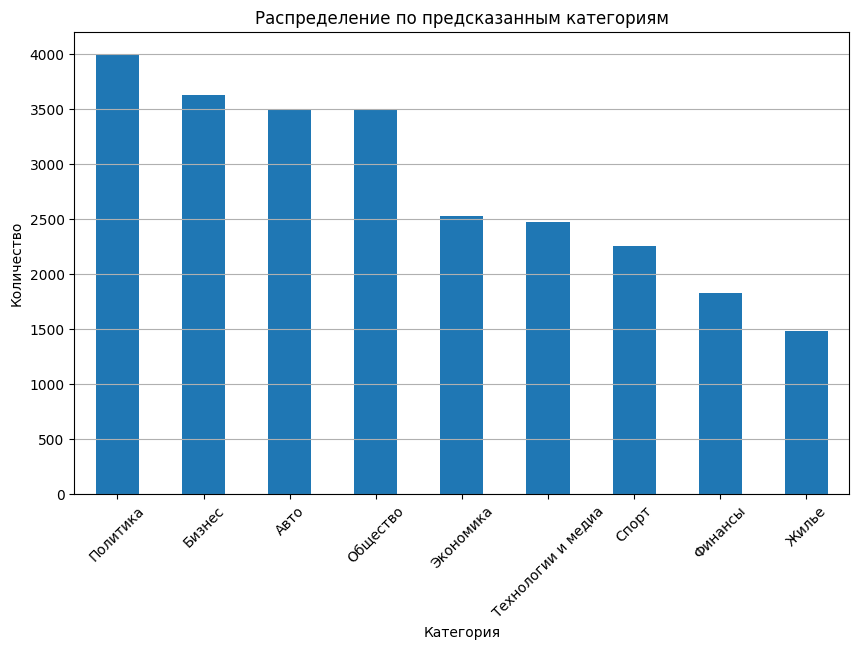

In [20]:
import matplotlib.pyplot as plt

category_counts = df["category"].value_counts()

plt.figure(figsize=(10, 6))
category_counts.plot(kind='bar')
plt.xlabel("Категория")
plt.ylabel("Количество")
plt.title("Распределение по предсказанным категориям")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

In [38]:
model.save_model("catboost_news_classifier_1.cbm")
joblib.dump(vectorizer, "tfidf_vectorizer_1.pkl")


✅ Модель сохранена: catboost_news_classifier_1.cbm
✅ Векторизатор сохранён: tfidf_vectorizer_1.pkl


In [39]:
!cp -r ./catboost_news_classifier_1 /content/drive/MyDrive/
!cp -r ./tfidf_vectorizer_1 /content/drive/MyDrive/

cp: cannot stat './catboost_news_classifier_1': No such file or directory
cp: cannot stat './tfidf_vectorizer_1': No such file or directory


In [40]:
!pwd
!ls -la

/content
total 215812
drwxr-xr-x 1 root root      4096 May  8 11:36 .
drwxr-xr-x 1 root root      4096 May  8 08:19 ..
drwxr-xr-x 4 root root      4096 May  8 08:28 catboost_info
-rw-r--r-- 1 root root 123214712 May  8 12:35 catboost_news_classifier_1.cbm
drwxr-xr-x 4 root root      4096 May  6 13:38 .config
drwx------ 6 root root      4096 May  8 08:23 drive
-rw-r--r-- 1 root root  26975543 May  8 11:38 final_dataset_limited_1500_per_category.xlsx
-rw-r--r-- 1 root root  10916266 May  8 08:27 final_dataset_limited_600_per_category.xlsx
-rw-r--r-- 1 root root  59618895 May  8 11:33 parsed_data_new_balanced.xlsx
drwxr-xr-x 1 root root      4096 May  6 13:38 sample_data
-rw-r--r-- 1 root root    224200 May  8 12:35 tfidf_vectorizer_1.pkl
